# Scikit-Image Model Deployment

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from skimage import (
    io,
    color,
    exposure,
    transform,
    feature
)
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
SEED = 42

## Data Preprocessing

In [5]:
# load dataset pickle
dataset = pickle.load(open('../STEP0_Dataset_Preprocessing/flowers.pkl', 'rb'))
dataset['description']
# '4555 80x80 RGB images of 45 classes.'

'4555 80x80 RGB images of 45 classes.'

In [6]:
X = dataset['data']
y = dataset['target']

In [7]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
print(X_train.shape, X_test.shape)
# (3644, 80, 80, 3) (911, 80, 80, 3)

(3644, 80, 80, 3) (911, 80, 80, 3)


### Feature Extraction

#### Histogram of Oriented Gradients (HOG)

In [8]:
testimg = io.imread('assets/Strelitzia.jpg')

In [9]:
# hog feature descriptor
feature_vector, hog_image = feature.hog(testimg, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 5))

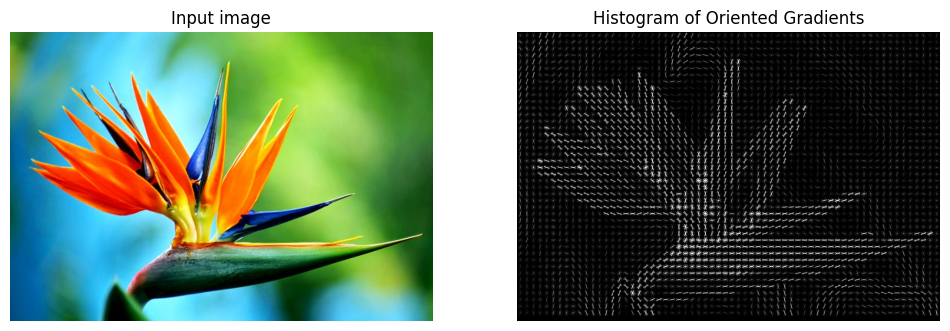

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(testimg, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

![Scikit-Image Introduction](./assets/Scikit_Image_Model_Deployment_01.webp)

In [11]:
class hog_transformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(3, 3)
    ):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        def local_hog(img):
            feature_vector = feature.hog(
                img,
                orientations=self.orientations,
                pixels_per_cell = self.pixels_per_cell,
                cells_per_block = self.cells_per_block,
                channel_axis=-1
            )
            
            return feature_vector
        
        return [local_hog(x) for x in X]

## Model Selection

### Feature Extraction

In [12]:
feature_extractor = hog_transformer()
scaler = StandardScaler()
model_sgd = SGDClassifier(loss='hinge', learning_rate='adaptive', eta0=0.1, early_stopping=True)

### Normalization

In [13]:
X_train_fv = feature_extractor.fit_transform(X_train)
X_test_fv = feature_extractor.transform(X_test)

In [14]:
X_train_fv_scaled = scaler.fit_transform(X_train_fv)
X_test_fv_scaled = scaler.transform(X_test_fv)

### SGD Classifier Fitting

In [15]:
model_sgd.fit(X_train_fv_scaled, y_train)

SGDClassifier(early_stopping=True, eta0=0.1, learning_rate='adaptive')

### SGD Model Evaluation

In [17]:
y_pred = model_sgd.predict(X_test_fv_scaled)

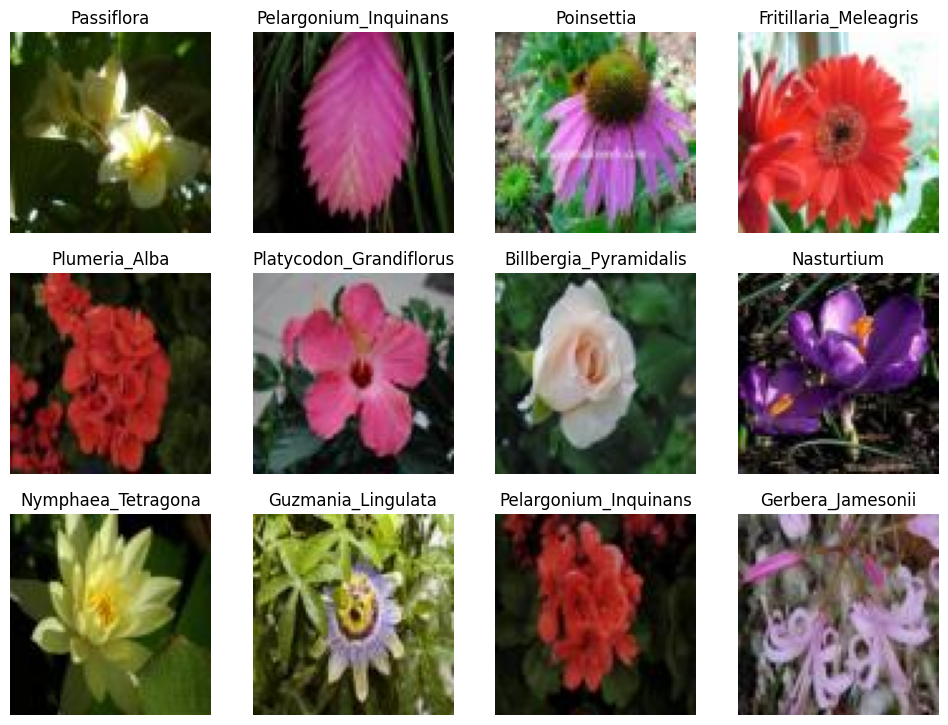

In [18]:
# plot predictions
ran_gen = np.random.default_rng()

plt.figure(figsize=(12, 12))

for i in range(12):
    ax = plt.subplot(4, 4, i+1)
    random_index = ran_gen.integers(low=0, high=403, size=1)
    plt.imshow(X_test[random_index[0]])
    plt.title(y_pred[random_index[0]])
    plt.axis(False)

plt.savefig('assets/Scikit_Image_Model_Deployment_02.webp', bbox_inches='tight')

![Scikit-Image Introduction](./assets/Scikit_Image_Model_Deployment_02.webp)

ValueError: The number of FixedLocator locations (45), usually from a call to set_ticks, does not match the number of labels (1).

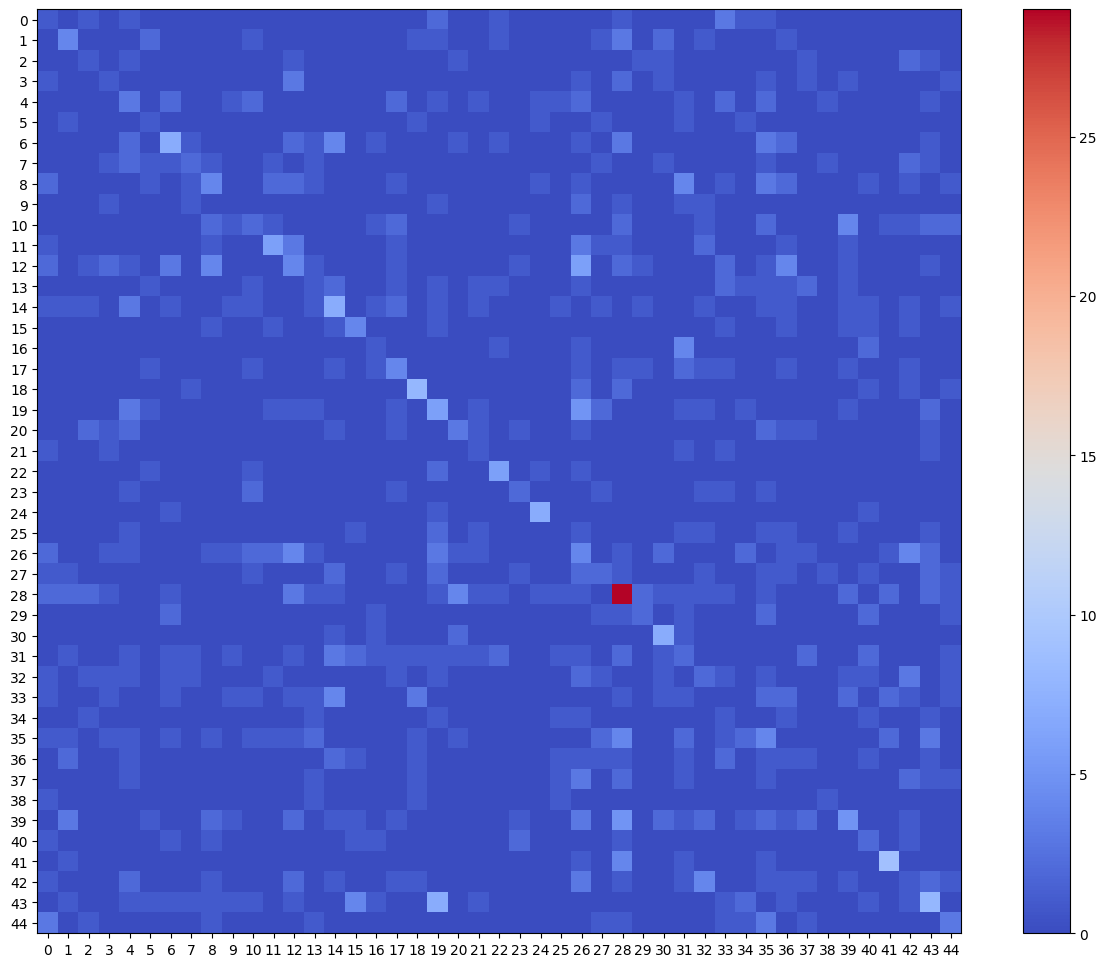

In [19]:
conf_mtx = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred.tolist()),
    display_labels=[False]
)

fig, ax = plt.subplots(figsize=(16,12))
conf_mtx.plot(ax=ax, cmap='coolwarm', include_values=False)

![Scikit-Image Introduction](./assets/Scikit_Image_Model_Deployment_03.webp)

In [20]:
eval_report = classification_report(y_test, y_pred, output_dict=True)
eval_df = pd.DataFrame(eval_report)

pd.options.display.max_rows = 50

eval_df.transpose()

,precision,recall,f1-score,support
Adenium,0.043478,0.083333,0.057143,12.000000
Alpinia_Purpurata,0.222222,0.222222,0.222222,18.000000
Alstroemeria_Aurantiaca,0.090909,0.100000,0.095238,10.000000
Anthurium_Andraeanum,0.083333,0.076923,0.080000,13.000000
Antirrhinum,0.103448,0.130435,0.115385,23.000000
Billbergia_Pyramidalis,0.090909,0.142857,0.111111,7.000000
Cattleya_Mossiae,0.291667,0.233333,0.259259,30.000000
Cirsium_Altissimum,0.222222,0.117647,0.153846,17.000000
Coccinia_Grandis,0.190476,0.137931,0.160000,29.000000
Crocus,0.000000,0.000000,0.000000,8.000000


|  | precision | recall | f1-score | support |
| -- | -- | -- | -- | -- |
| Adenium | 0.000000 | 0.000000 | 0.000000 | 12.000000 |
| Alpinia_Purpurata | 0.235294 | 0.222222 | 0.228571 | 18.000000 |
| Alstroemeria_Aurantiaca | 0.000000 | 0.000000 | 0.000000 | 10.000000 |
| Anthurium_Andraeanum | 0.200000 | 0.153846 | 0.173913 | 13.000000 |
| Antirrhinum | 0.080000 | 0.086957 | 0.083333 | 23.000000 |
| Billbergia_Pyramidalis | 0.000000 | 0.000000 | 0.000000 | 7.000000 |
| Cattleya_Mossiae | 0.227273 | 0.166667 | 0.192308 | 30.000000 |
| Cirsium_Altissimum | 0.133333 | 0.117647 | 0.125000 | 17.000000 |
| Coccinia_Grandis | 0.068966 | 0.068966 | 0.068966 | 29.000000 |
| Crocus | 0.000000 | 0.000000 | 0.000000 | 8.000000 |
| Cyclamen | 0.250000 | 0.160000 | 0.195122 | 25.000000 |
| Dahlia_Bishop_of_Llandaff | 0.272727 | 0.285714 | 0.279070 | 21.000000 |
| Datura_Metel | 0.018519 | 0.026316 | 0.021739 | 38.000000 |
| Dianthus_Barbatus | 0.125000 | 0.111111 | 0.117647 | 18.000000 |
| Digitalis | 0.289474 | 0.343750 | 0.314286 | 32.000000 |
| Echinacea_Purpurea | 0.250000 | 0.307692 | 0.275862 | 13.000000 |
| Echinops_Bannaticus | 0.000000 | 0.000000 | 0.000000 | 9.000000 |
| Fritillaria_Meleagris | 0.130435 | 0.166667 | 0.146341 | 18.000000 |
| Gazania_Rigens | 0.105263 | 0.125000 | 0.114286 | 16.000000 |
| Gerbera_Jamesonii | 0.102564 | 0.142857 | 0.119403 | 28.000000 |
| Gladiolus | 0.095238 | 0.111111 | 0.102564 | 18.000000 |
| Guzmania_Lingulata | 0.166667 | 0.166667 | 0.166667 | 6.000000 |
| Helianthus_Annuus | 0.312500 | 0.416667 | 0.357143 | 12.000000 |
| Iris_Pseudacorus | 0.222222 | 0.200000 | 0.210526 | 10.000000 |
| Leucanthemum | 0.000000 | 0.000000 | 0.000000 | 10.000000 |
| Narcissus_Pseudonarcissus | 0.187500 | 0.250000 | 0.214286 | 12.000000 |
| Nasturtium | 0.076923 | 0.105263 | 0.088889 | 38.000000 |
| Nerine_Sarniensis | 0.111111 | 0.090909 | 0.100000 | 22.000000 |
| Nymphaea_Tetragona | 0.409091 | 0.545455 | 0.467532 | 66.000000 |
| Oenothera_Suffrutescens | 0.181818 | 0.153846 | 0.166667 | 13.000000 |
| Paphiopedilum_Micranthum | 0.555556 | 0.416667 | 0.476190 | 12.000000 |
| Passiflora | 0.217391 | 0.161290 | 0.185185 | 31.000000 |
| Pelargonium_Inquinans | 0.266667 | 0.173913 | 0.210526 | 23.000000 |
| Petunia | 0.030303 | 0.037037 | 0.033333 | 27.000000 |
| Platycodon_Grandiflorus | 0.000000 | 0.000000 | 0.000000 | 9.000000 |
| Plumeria_Alba | 0.190476 | 0.121212 | 0.148148 | 33.000000 |
| Poinsettia | 0.166667 | 0.105263 | 0.129032 | 19.000000 |
| Primula_Vulgaris | 0.214286 | 0.200000 | 0.206897 | 15.000000 |
| Protea_Cynaroides | 0.000000 | 0.000000 | 0.000000 | 5.000000 |
| Rose | 0.111111 | 0.078947 | 0.092308 | 38.000000 |
| Rudbeckia | 0.300000 | 0.272727 | 0.285714 | 11.000000 |
| Strelitzia_Reginae | 0.368421 | 0.411765 | 0.388889 | 17.000000 |
| Tropaeolum_Majus | 0.120000 | 0.115385 | 0.117647 | 26.000000 |
| Tussilago | 0.235294 | 0.222222 | 0.228571 | 36.000000 |
| Viola_Tricolor | 0.227273 | 0.294118 | 0.256410 | 17.000000 |
| accuracy | 0.180022 | 0.180022 | 0.180022 | 0.180022 |
| macro avg | 0.161230 | 0.158575 | 0.157533 | 911.000000 |
| weighted avg | 0.177870 | 0.180022 | 0.175935 | 911.000000 |

## Hyperparameter Tuning

### Training Pipeline

In [21]:
train_pipeline = Pipeline([
    ('feature_extraction', hog_transformer(
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(3, 3))
    ),
    ('normalization', StandardScaler()),
    ('model_training', SGDClassifier(
        loss='hinge', eta0=0.1,
        learning_rate='adaptive',
        early_stopping=True)
    )
])

In [22]:
train_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_extraction', hog_transformer()),
                ('normalization', StandardScaler()),
                ('model_training',
                 SGDClassifier(early_stopping=True, eta0=0.1,
                               learning_rate='adaptive'))])

In [23]:
y_pred_pipe = train_pipeline.predict(X_test)

In [24]:
eval_report = classification_report(y_test, y_pred_pipe, output_dict=True)
eval_df = pd.DataFrame(eval_report)

pd.options.display.max_rows = 50
eval_df.transpose()

,precision,recall,f1-score,support
Adenium,0.000000,0.000000,0.000000,12.000000
Alpinia_Purpurata,0.153846,0.222222,0.181818,18.000000
Alstroemeria_Aurantiaca,0.058824,0.100000,0.074074,10.000000
Anthurium_Andraeanum,0.166667,0.153846,0.160000,13.000000
Antirrhinum,0.040000,0.043478,0.041667,23.000000
Billbergia_Pyramidalis,0.000000,0.000000,0.000000,7.000000
Cattleya_Mossiae,0.363636,0.266667,0.307692,30.000000
Cirsium_Altissimum,0.105263,0.117647,0.111111,17.000000
Coccinia_Grandis,0.052632,0.034483,0.041667,29.000000
Crocus,0.000000,0.000000,0.000000,8.000000


|  | precision | recall | f1-score | support |
| -- | -- | -- | -- | -- |
| Adenium | 0.071429 | 0.083333 | 0.076923 | 12.00000 |
| Alpinia_Purpurata | 0.173913 | 0.222222 | 0.195122 | 18.00000 |
| Alstroemeria_Aurantiaca | 0.111111 | 0.100000 | 0.105263 | 10.00000 |
| Anthurium_Andraeanum | 0.000000 | 0.000000 | 0.000000 | 13.00000 |
| Antirrhinum | 0.130435 | 0.260870 | 0.173913 | 23.00000 |
| Billbergia_Pyramidalis | 0.000000 | 0.000000 | 0.000000 | 7.00000 |
| Cattleya_Mossiae | 0.281250 | 0.300000 | 0.290323 | 30.00000 |
| Cirsium_Altissimum | 0.111111 | 0.117647 | 0.114286 | 17.00000 |
| Coccinia_Grandis | 0.000000 | 0.000000 | 0.000000 | 29.00000 |
| Crocus | 0.000000 | 0.000000 | 0.000000 | 8.00000 |
| Cyclamen | 0.260870 | 0.240000 | 0.250000 | 25.00000 |
| Dahlia_Bishop_of_Llandaff | 0.266667 | 0.190476 | 0.222222 | 21.00000 |
| Datura_Metel | 0.025000 | 0.026316 | 0.025641 | 38.00000 |
| Dianthus_Barbatus | 0.076923 | 0.055556 | 0.064516 | 18.00000 |
| Digitalis | 0.280000 | 0.218750 | 0.245614 | 32.00000 |
| Echinacea_Purpurea | 0.312500 | 0.384615 | 0.344828 | 13.00000 |
| Echinops_Bannaticus | 0.000000 | 0.000000 | 0.000000 | 9.00000 |
| Fritillaria_Meleagris | 0.300000 | 0.333333 | 0.315789 | 18.00000 |
| Gazania_Rigens | 0.285714 | 0.250000 | 0.266667 | 16.00000 |
| Gerbera_Jamesonii | 0.324324 | 0.428571 | 0.369231 | 28.00000 |
| Gladiolus | 0.000000 | 0.000000 | 0.000000 | 18.00000 |
| Guzmania_Lingulata | 0.083333 | 0.166667 | 0.111111 | 6.00000 |
| Helianthus_Annuus | 0.461538 | 0.500000 | 0.480000 | 12.00000 |
| Iris_Pseudacorus | 0.250000 | 0.200000 | 0.222222 | 10.00000 |
| Leucanthemum | 0.400000 | 0.200000 | 0.266667 | 10.00000 |
| Narcissus_Pseudonarcissus | 0.076923 | 0.083333 | 0.080000 | 12.00000 |
| Nasturtium | 0.034483 | 0.026316 | 0.029851 | 38.00000 |
| Nerine_Sarniensis | 0.150000 | 0.136364 | 0.142857 | 22.00000 |
| Nymphaea_Tetragona | 0.484375 | 0.469697 | 0.476923 | 66.00000 |
| Oenothera_Suffrutescens | 0.230769 | 0.230769 | 0.230769 | 13.00000 |
| Paphiopedilum_Micranthum | 0.545455 | 0.500000 | 0.521739 | 12.00000 |
| Passiflora | 0.258065 | 0.258065 | 0.258065 | 31.00000 |
| Pelargonium_Inquinans | 0.166667 | 0.130435 | 0.146341 | 23.00000 |
| Petunia | 0.040000 | 0.037037 | 0.038462 | 27.00000 |
| Platycodon_Grandiflorus | 0.000000 | 0.000000 | 0.000000 | 9.00000 |
| Plumeria_Alba | 0.121212 | 0.121212 | 0.121212 | 33.00000 |
| Poinsettia | 0.000000 | 0.000000 | 0.000000 | 19.00000 |
| Primula_Vulgaris | 0.055556 | 0.066667 | 0.060606 | 15.00000 |
| Protea_Cynaroides | 0.000000 | 0.000000 | 0.000000 | 5.00000 |
| Rose | 0.321429 | 0.236842 | 0.272727 | 38.00000 |
| Rudbeckia | 0.142857 | 0.181818 | 0.160000 | 11.00000 |
| Strelitzia_Reginae | 0.296296 | 0.470588 | 0.363636 | 17.00000 |
| Tropaeolum_Majus | 0.125000 | 0.115385 | 0.120000 | 26.00000 |
| Tussilago | 0.393939 | 0.361111 | 0.376812 | 36.00000 |
| Viola_Tricolor | 0.178571 | 0.294118 | 0.222222 | 17.00000 |
| accuracy | 0.199780 | 0.199780 | 0.199780 | 0.19978 |
| macro avg | 0.173949 | 0.177736 | 0.172501 | 911.00000 |
| weighted avg | 0.199319 | 0.199780 | 0.196704 | 911.00000 |

### GridSearch

In [34]:
estimator = Pipeline([
    ('feature_extraction', hog_transformer()),
    ('normalization', StandardScaler()),
    ('model_training', SGDClassifier())
])

In [35]:
param_grid = [
    {
        'feature_extraction__orientations': [7, 8, 9, 10, 11],
        'feature_extraction__pixels_per_cell': [(7, 7), (8, 8), (9, 9)],
        'feature_extraction__cells_per_block': [(2, 2), (3, 3), (4, 4)],
        'model_training__loss': ['hinge', 'squared_hinge', 'perceptron'],
        'model_training__eta0': [0.001, 0.1, 1],
        'model_training__learning_rate': ['optimal', 'adaptive']
    }
]

In [36]:
model_grid = GridSearchCV(
    estimator,
    param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)

In [37]:
model_grid.fit(X_train, y_train)
# Fitting 3 folds for each of 810 candidates, totalling 2430 fits
# time for a coffee break :)

Fitting 3 folds for each of 810 candidates, totalling 2430 fits


/home/xiaodie/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=perceptron; total time= 1.3min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=perceptron; total time= 1.2min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 1.3min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time= 

[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=perceptron; total time= 1.3min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 1.7min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time= 1.1min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 1.9min
[

[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time= 1.6min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 1.5min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time= 1.1min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 

[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time= 1.3min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 1.7min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=hinge; total time= 1.1min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time= 1.2min
[CV] END f

[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  57.3s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 1.5min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  46.4s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  45.9s
[CV] E

[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  56.3s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  52.8s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 1.5min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  45.3s
[CV] END

[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 1.6min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  44.1s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time=  47.3s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total tim

[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 1.6min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  44.6s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=hinge; total time=  57.9s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  43.5s


[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  39.9s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 1.6min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  49.8s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 1.5m

[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 1.6min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  44.6s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 1.5min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  33.1

[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 1.6min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  51.2s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  43.0s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 1.5min
[CV] END f

[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 1.6min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  47.7s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  43.3s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 1.5min
[C

[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 1.4min
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  27.4s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=hinge; total time=  38.3s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  25

[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  27.1s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time=  30.1s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  28.6s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; 

[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  30.3s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time=  31.0s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  27.5s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; tot

[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  27.5s
[CV] END feature_extraction__cells_per_block=(2, 2), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time=  51.7s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  41.1s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 1.4min
[CV] END

[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 2.0min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  40.1s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 2.1min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  36.9s
[C

[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  48.1s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 2.1min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  39.0s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time=

[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 2.2min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 1.9min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 1.1min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  36.3s
[CV]

[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 1.5min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  33.7s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 1.7min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  31.9s
[C

[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 1.1min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  31.6s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 1.1min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 1.2min
[CV] END f

[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  31.5s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 1.1min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  57.0s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 2.0min


[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  29.8s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 1.2min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time= 1.0min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total 

[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  59.1s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 2.6min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  53.1s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  53.3s
[CV] E

[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  45.6s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 2.1min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  43.4s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 2.1m

[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 2.5min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 1.5min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 2.2min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 2.0m

[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  44.5s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 2.1min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  31.4s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  

[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  45.6s
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 2.2min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 2.1min
[CV] END feature_extraction__cells_per_block=(3, 3), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  36.0s
[CV] END featur

[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=7, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 1.3min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  56.6s
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 2.4min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  5

[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 2.4min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  57.7s
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 3.0min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  57.2s
[CV] END f

[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 2.9min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  57.2s
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 3.0min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  51.8s
[CV] END fea

[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 3.0min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  49.9s
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 1.8min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=8, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 1.5min


[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  33.8s
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  33.5s
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 1.0min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  39.8s


[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  34.9s
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 1.2min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  39.1s
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  30.5s
[C

[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 2.6min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  34.5s
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 1.1min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=9, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time=  58.9s


[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=perceptron; total time= 1.2min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 2.9min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time= 1.1min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=10, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=hinge; total ti

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_extraction',
                                        hog_transformer()),
                                       ('normalization', StandardScaler()),
                                       ('model_training', SGDClassifier())]),
             n_jobs=-1,
             param_grid=[{'feature_extraction__cells_per_block': [(2, 2),
                                                                  (3, 3),
                                                                  (4, 4)],
                          'feature_extraction__orientations': [7, 8, 9, 10, 11],
                          'feature_extraction__pixels_per_cell': [(7, 7),
                                                                  (8, 8),
                                                                  (9, 9)],
                          'model_training__eta0': [0.001, 0.1, 1],
                          'model_training__learning_rate': ['optimal',
                                                            'adaptive'],
                          'model_training__loss': ['hinge', 'squared_hinge',
                                                   'perceptron']}],
             scoring='accuracy', verbose=2)

### Best Model Evaluation

In [56]:
model_grid.best_params_
# {'feature_extraction__cells_per_block': (3, 3),
#  'feature_extraction__orientations': 10,
#  'feature_extraction__pixels_per_cell': (7, 7),
#  'model_training__eta0': 1,
#  'model_training__learning_rate': 'optimal',
#  'model_training__loss': 'hinge'}

{'feature_extraction__cells_per_block': (3, 3),
 'feature_extraction__orientations': 10,
 'feature_extraction__pixels_per_cell': (7, 7),
 'model_training__eta0': 1,
 'model_training__learning_rate': 'optimal',
 'model_training__loss': 'hinge'}

In [39]:
model_grid.best_score_
# 0.28018567105759734

0.28018567105759734

[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time= 1.1min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=perceptron; total time= 1.1min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=perceptron; total time= 3.1min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=perceptron; total time= 1

[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 4.0min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time= 1.2min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 4.3min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  53.7s


[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 3.9min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time= 1.2min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(7, 7), model_training__eta0=1, model_training__learning_rate=adaptive, model_training__loss=hinge; total time= 4.1min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(8, 8), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=hinge; total time=  57.7s


[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=optimal, model_training__loss=perceptron; total time=  33.9s
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.001, model_training__learning_rate=adaptive, model_training__loss=squared_hinge; total time= 1.3min
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.1, model_training__learning_rate=optimal, model_training__loss=squared_hinge; total time=  38.4s
[CV] END feature_extraction__cells_per_block=(4, 4), feature_extraction__orientations=11, feature_extraction__pixels_per_cell=(9, 9), model_training__eta0=0.1, model_training__learning_rate=adaptive, model_training__loss=hinge; total ti

In [40]:
model_best = model_grid.best_estimator_

In [41]:
y_pred_best = model_best.predict(X_test)

In [42]:
eval_report_best = classification_report(y_test, y_pred_best, output_dict=True)
eval_best_df = pd.DataFrame(eval_report_best)
eval_best_df.transpose()

/home/xiaodie/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaodie/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaodie/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
class_label_103,0.363636,0.235294,0.285714,17.00000
class_label_104,0.200000,0.076923,0.111111,13.00000
class_label_112,0.750000,0.250000,0.375000,12.00000
class_label_113,0.375000,0.321429,0.346154,28.00000
class_label_12,0.375000,0.230769,0.285714,13.00000
class_label_13,0.000000,0.000000,0.000000,10.00000
class_label_14,0.090909,0.086957,0.088889,23.00000
class_label_15,0.166667,0.166667,0.166667,18.00000
class_label_17,0.375000,0.250000,0.300000,12.00000
class_label_2,0.363636,0.421053,0.390244,19.00000


|  | precision | recall | f1-score | support |
| -- | -- | -- | -- | -- |
| class_label_103 | 0.363636 | 0.235294 | 0.285714 | 17.00000 |
| class_label_104 | 0.200000 | 0.076923 | 0.111111 | 13.00000 |
| class_label_112 | 0.750000 | 0.250000 | 0.375000 | 12.00000 |
| class_label_113 | 0.375000 | 0.321429 | 0.346154 | 28.00000 |
| class_label_12 | 0.375000 | 0.230769 | 0.285714 | 13.00000 |
| class_label_13 | 0.000000 | 0.000000 | 0.000000 | 10.00000 |
| class_label_14 | 0.090909 | 0.086957 | 0.088889 | 23.00000 |
| class_label_15 | 0.166667 | 0.166667 | 0.166667 | 18.00000 |
| class_label_17 | 0.375000 | 0.250000 | 0.300000 | 12.00000 |
| class_label_2 | 0.363636 | 0.421053 | 0.390244 | 19.00000 |
| class_label_24 | 0.235294 | 0.153846 | 0.186047 | 26.00000 |
| class_label_27 | 0.357143 | 0.277778 | 0.312500 | 18.00000 |
| class_label_36 | 0.833333 | 0.500000 | 0.625000 | 10.00000 |
| class_label_38 | 0.000000 | 0.000000 | 0.000000 | 7.00000 |
| class_label_39 | 0.666667 | 0.400000 | 0.500000 | 5.00000 |
| class_label_4 | 0.115385 | 0.157895 | 0.133333 | 38.00000 |
| class_label_40 | 0.066667 | 0.071429 | 0.068966 | 28.00000 |
| class_label_41 | 0.000000 | 0.000000 | 0.000000 | 9.00000 |
| class_label_42 | 0.111111 | 0.083333 | 0.095238 | 12.00000 |
| class_label_47 | 0.071429 | 0.055556 | 0.062500 | 18.00000 |
| class_label_52 | 0.506329 | 0.606061 | 0.551724 | 66.00000 |
| class_label_54 | 0.243243 | 0.300000 | 0.268657 | 30.00000 |
| class_label_56 | 0.076923 | 0.055556 | 0.064516 | 18.00000 |
| class_label_58 | 0.588235 | 0.588235 | 0.588235 | 17.00000 |
| class_label_59 | 0.833333 | 0.384615 | 0.526316 | 13.00000 |
| class_label_60 | 0.000000 | 0.000000 | 0.000000 | 9.00000 |
| class_label_62 | 0.315789 | 0.240000 | 0.272727 | 25.00000 |
| class_label_63 | 0.875000 | 0.583333 | 0.700000 | 12.00000 |
| class_label_65 | 0.200000 | 0.125000 | 0.153846 | 8.00000 |
| class_label_66 | 0.400000 | 0.375000 | 0.387097 | 16.00000 |
| class_label_67 | 0.048780 | 0.074074 | 0.058824 | 27.00000 |
| class_label_7 | 0.138889 | 0.227273 | 0.172414 | 22.00000 |
| class_label_70 | 0.210526 | 0.242424 | 0.225352 | 33.00000 |
| class_label_73 | 1.000000 | 0.333333 | 0.500000 | 6.00000 |
| class_label_74 | 0.428571 | 0.500000 | 0.461538 | 36.00000 |
| class_label_75 | 0.571429 | 0.400000 | 0.470588 | 10.00000 |
| class_label_77 | 0.633333 | 0.612903 | 0.622951 | 31.00000 |
| class_label_82 | 0.250000 | 0.304348 | 0.274510 | 23.00000 |
| class_label_83 | 0.250000 | 0.476190 | 0.327869 | 21.00000 |
| class_label_84 | 0.285714 | 0.437500 | 0.345679 | 32.00000 |
| class_label_85 | 0.368421 | 0.358974 | 0.363636 | 39.00000 |
| class_label_86 | 0.444444 | 0.235294 | 0.307692 | 17.00000 |
| class_label_95 | 0.750000 | 0.272727 | 0.400000 | 11.00000 |
| class_label_96 | 0.140351 | 0.205128 | 0.166667 | 39.00000 |
| class_label_97 | 0.272727 | 0.200000 | 0.230769 | 15.00000 |
| accuracy | 0.293860 | 0.293860 | 0.293860 | 0.29386 |
| macro avg | 0.341087 | 0.263931 | 0.283882 | 912.00000 |
| weighted avg | 0.318032 | 0.293860 | 0.294243 | 912.00000 |

ValueError: The number of FixedLocator locations (45), usually from a call to set_ticks, does not match the number of labels (1).

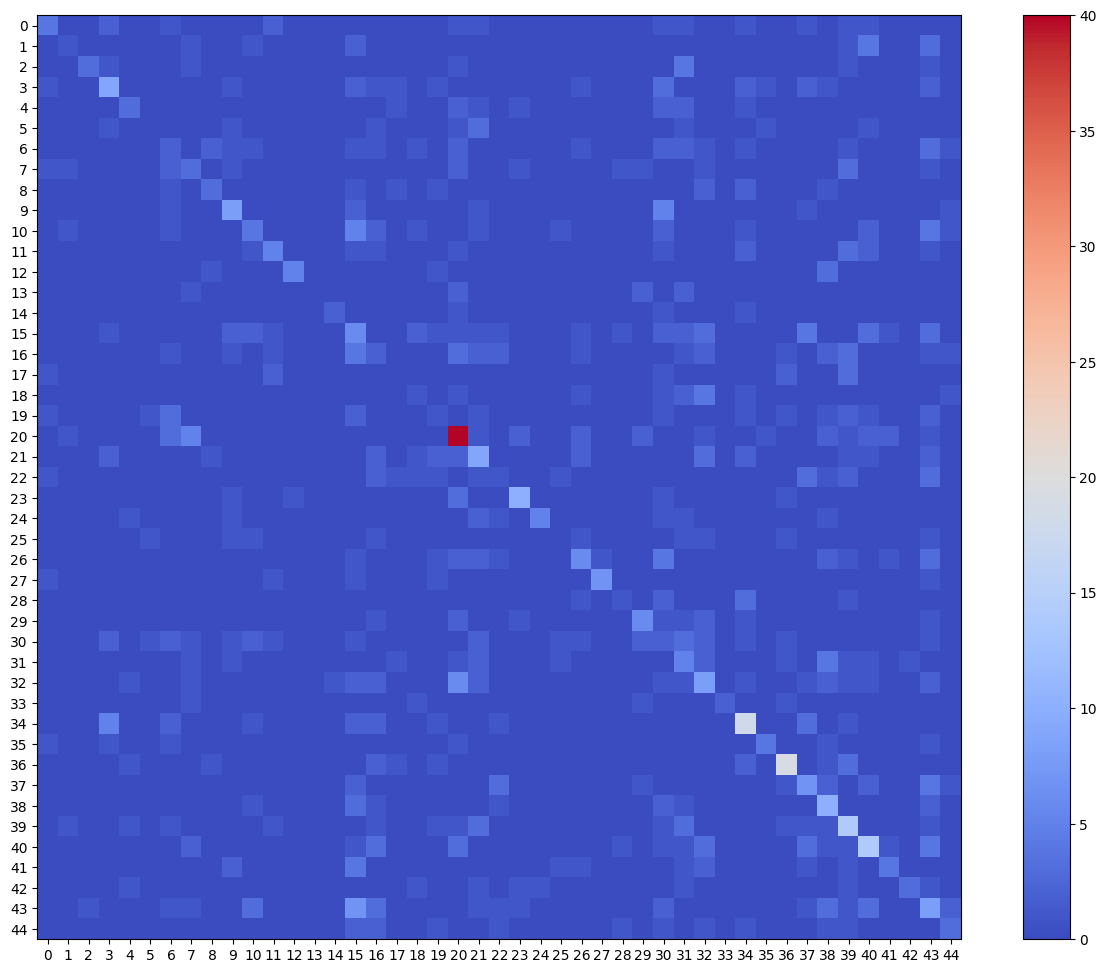

In [44]:
conf_mtx = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_best.tolist()),
    display_labels=[False]
)

fig, ax = plt.subplots(figsize=(16,12))
conf_mtx.plot(ax=ax, cmap='coolwarm', include_values=False)

![Scikit-Image Introduction](./assets/Scikit_Image_Model_Deployment_04.webp)

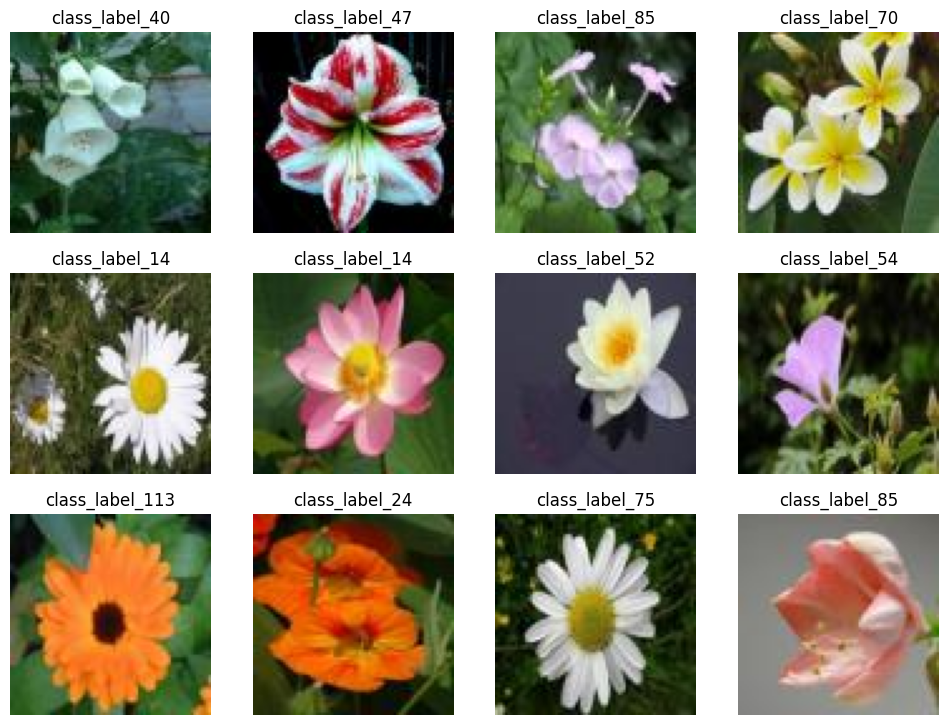

In [45]:
# plot predictions
ran_gen = np.random.default_rng()

plt.figure(figsize=(12, 12))

for i in range(12):
    ax = plt.subplot(4, 4, i+1)
    random_index = ran_gen.integers(low=0, high=403, size=1)
    plt.imshow(X_test[random_index[0]])
    plt.title(y_pred_best[random_index[0]])
    plt.axis(False)

plt.savefig('assets/Scikit_Image_Model_Deployment_05.webp', bbox_inches='tight')

![Scikit-Image Introduction](./assets/Scikit_Image_Model_Deployment_05.webp)

## Deployment Model

### Model Training

In [25]:
best_params = {'feature_extraction__cells_per_block': (3, 3),
 'feature_extraction__orientations': 10,
 'feature_extraction__pixels_per_cell': (7, 7),
 'model_training__eta0': 1,
 'model_training__learning_rate': 'optimal',
 'model_training__loss': 'hinge'}

In [26]:
feature_extractor_pipe = make_pipeline(
    hog_transformer(
        orientations=10,
        pixels_per_cell=(7, 7),
        cells_per_block=(3, 3))
    )

In [27]:
# fit model to entire dataset
feature_vectors = feature_extractor_pipe.fit_transform(X)

In [28]:
normalizer = StandardScaler()

In [29]:
feature_normed = normalizer.fit_transform(feature_vectors)

In [30]:
classifier = SGDClassifier(
        loss='hinge', eta0=1,
        learning_rate='optimal',
        early_stopping=True
)

In [31]:
classifier.fit(feature_normed, y)

SGDClassifier(early_stopping=True, eta0=1)

### Model Evaluation

In [32]:
feature_vectors_test = feature_extractor_pipe.transform(X_test)
feature_normed_test = normalizer.transform(feature_vectors_test)
y_pred_deploy = classifier.predict(feature_normed_test)

In [33]:
eval_report_best = classification_report(y_test, y_pred_deploy, output_dict=True)
eval_best_df = pd.DataFrame(eval_report_best)
eval_best_df.transpose()

,precision,recall,f1-score,support
Adenium,1.000000,0.916667,0.956522,12.000000
Alpinia_Purpurata,0.894737,0.944444,0.918919,18.000000
Alstroemeria_Aurantiaca,1.000000,0.800000,0.888889,10.000000
Anthurium_Andraeanum,1.000000,0.846154,0.916667,13.000000
Antirrhinum,0.782609,0.782609,0.782609,23.000000
Billbergia_Pyramidalis,0.857143,0.857143,0.857143,7.000000
Cattleya_Mossiae,0.965517,0.933333,0.949153,30.000000
Cirsium_Altissimum,1.000000,1.000000,1.000000,17.000000
Coccinia_Grandis,0.851852,0.793103,0.821429,29.000000
Crocus,0.875000,0.875000,0.875000,8.000000


|  | precision | recall | f1-score | support |
| -- | -- | -- | -- | -- |
| Adenium | 1.000000 | 0.916667 | 0.956522 | 12.000000 |
| Alpinia_Purpurata | 0.894737 | 0.944444 | 0.918919 | 18.000000 |
| Alstroemeria_Aurantiaca | 1.000000 | 0.800000 | 0.888889 | 10.000000 |
| Anthurium_Andraeanum | 1.000000 | 1.000000 | 1.000000 | 13.000000 |
| Antirrhinum | 0.950000 | 0.826087 | 0.883721 | 23.000000 |
| Billbergia_Pyramidalis | 1.000000 | 0.857143 | 0.923077 | 7.000000 |
| Cattleya_Mossiae | 0.928571 | 0.866667 | 0.896552 | 30.000000 |
| Cirsium_Altissimum | 0.941176 | 0.941176 | 0.941176 | 17.000000 |
| Coccinia_Grandis | 0.787879 | 0.896552 | 0.838710 | 29.000000 |
| Crocus | 1.000000 | 0.875000 | 0.933333 | 8.000000 |
| Cyclamen | 0.888889 | 0.960000 | 0.923077 | 25.000000 |
| Dahlia_Bishop_of_Llandaff | 0.894737 | 0.809524 | 0.850000 | 21.000000 |
| Datura_Metel | 0.916667 | 0.868421 | 0.891892 | 38.000000 |
| Dianthus_Barbatus | 0.944444 | 0.944444 | 0.944444 | 18.000000 |
| Digitalis | 0.903226 | 0.875000 | 0.888889 | 32.000000 |
| Echinacea_Purpurea | 1.000000 | 1.000000 | 1.000000 | 13.000000 |
| Echinops_Bannaticus | 1.000000 | 0.888889 | 0.941176 | 9.000000 |
| Fritillaria_Meleagris | 0.894737 | 0.944444 | 0.918919 | 18.000000 |
| Gazania_Rigens | 0.937500 | 0.937500 | 0.937500 | 16.000000 |
| Gerbera_Jamesonii | 0.892857 | 0.892857 | 0.892857 | 28.000000 |
| Gladiolus | 1.000000 | 0.833333 | 0.909091 | 18.000000 |
| Guzmania_Lingulata | 1.000000 | 1.000000 | 1.000000 | 6.000000 |
| Helianthus_Annuus | 1.000000 | 1.000000 | 1.000000 | 12.000000 |
| Iris_Pseudacorus | 1.000000 | 0.900000 | 0.947368 | 10.000000 |
| Leucanthemum | 1.000000 | 0.900000 | 0.947368 | 10.000000 |
| Narcissus_Pseudonarcissus | 0.923077 | 1.000000 | 0.960000 | 12.000000 |
| Nasturtium | 0.795455 | 0.921053 | 0.853659 | 38.000000 |
| Nerine_Sarniensis | 0.840000 | 0.954545 | 0.893617 | 22.000000 |
| Nymphaea_Tetragona | 0.969231 | 0.954545 | 0.961832 | 66.000000 |
| Oenothera_Suffrutescens | 0.857143 | 0.923077 | 0.888889 | 13.000000 |
| Paphiopedilum_Micranthum | 1.000000 | 0.916667 | 0.956522 | 12.000000 |
| Passiflora | 0.878788 | 0.935484 | 0.906250 | 31.000000 |
| Pelargonium_Inquinans | 0.958333 | 1.000000 | 0.978723 | 23.000000 |
| Petunia | 0.954545 | 0.777778 | 0.857143 | 27.000000 |
| Platycodon_Grandiflorus | 1.000000 | 0.777778 | 0.875000 | 9.000000 |
| Plumeria_Alba | 0.833333 | 0.909091 | 0.869565 | 33.000000 |
| Poinsettia | 0.947368 | 0.947368 | 0.947368 | 19.000000 |
| Primula_Vulgaris | 0.933333 | 0.933333 | 0.933333 | 15.000000 |
| Protea_Cynaroides | 1.000000 | 0.800000 | 0.888889 | 5.000000 |
| Rose | 0.900000 | 0.947368 | 0.923077 | 38.000000 |
| Rudbeckia | 1.000000 | 0.909091 | 0.952381 | 11.000000 |
| Strelitzia_Reginae | 0.941176 | 0.941176 | 0.941176 | 17.000000 |
| Tropaeolum_Majus | 0.892857 | 0.961538 | 0.925926 | 26.000000 |
| Tussilago | 0.894737 | 0.944444 | 0.918919 | 36.000000 |
| Viola_Tricolor | 0.888889 | 0.941176 | 0.914286 | 17.000000 |
| accuracy | 0.915477 | 0.915477 | 0.915477 | 0.915477 |
| macro avg | 0.937415 | 0.912748 | 0.922667 | 911.000000 |
| weighted avg | 0.919543 | 0.915477 | 0.915601 | 911.000000 |

### Model Export

In [34]:
# save the model
output = open('../STEP3_Webfrontend_Deployment/static/models/sgd_model_deployment.pkl', 'wb')
pickle.dump(classifier, output)

In [35]:
# save fitted normalizer
output = open('../STEP3_Webfrontend_Deployment/static/models/sgd_model_deployment_scaler.pkl', 'wb')
pickle.dump(normalizer, output)